In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [86]:
pd.set_option('display.max_columns', 500)

In [87]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [88]:
key_path = './service_account/gentle-keyword-423715-j0-03be08ad6412.json'

credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/bigquery"]
)

In [89]:
from google.cloud import bigquery

client = bigquery.Client(
    credentials = credentials,
    project=credentials.project_id
)

In [90]:
query = """
SELECT
  u.id user_id,
  DATE(EXTRACT(YEAR FROM u.created_at), EXTRACT(MONTH FROM u.created_at), 1) created_account_date,
  u.age,
  o.order_id,
  o.num_of_item,
  DATE(EXTRACT(YEAR FROM o.created_at), EXTRACT(MONTH FROM o.created_at), 1) order_date,
  oi.sale_price * o.num_of_item revenue,
  e.session_id,
  e.id event_id,
  e.traffic_source traffic_session,
FROM `bigquery-public-data.thelook_ecommerce.users` u
LEFT JOIN `bigquery-public-data.thelook_ecommerce.order_items` oi
  ON oi.user_id = u.id
LEFT JOIN `bigquery-public-data.thelook_ecommerce.orders` o
  ON u.id = o.user_id AND oi.order_id = o.order_id
INNER JOIN `bigquery-public-data.thelook_ecommerce.products` p
  ON oi.product_id = p.id
LEFT JOIN `bigquery-public-data.thelook_ecommerce.events` e
  ON u.id = e.id
WHERE 
  o.status = 'Complete'
"""

df = client.query(query).to_dataframe()
print(df.info())
df.head()

C:\Users\Baha Tegar\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45632 entries, 0 to 45631
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               45632 non-null  Int64  
 1   created_account_date  45632 non-null  dbdate 
 2   age                   45632 non-null  Int64  
 3   order_id              45632 non-null  Int64  
 4   num_of_item           45632 non-null  Int64  
 5   order_date            45632 non-null  dbdate 
 6   revenue               45632 non-null  float64
 7   session_id            45632 non-null  object 
 8   event_id              45632 non-null  Int64  
 9   traffic_session       45632 non-null  object 
dtypes: Int64(5), dbdate(2), float64(1), object(2)
memory usage: 3.7+ MB
None


,user_id,created_account_date,age,order_id,num_of_item,order_date,revenue,session_id,event_id,traffic_session
0,80984,2022-08-01,46,101074,1,2023-12-01,7.99,014baa81-b4ca-438b-ab85-2aaeeea21b9f,80984,Email
1,64166,2022-08-01,58,79957,4,2023-01-01,92.00,1b4014ab-edf7-4859-9178-12c6c0d16b61,64166,Organic
2,62779,2022-08-01,41,78218,1,2023-02-01,25.00,f1af6ebb-cb3c-472a-a226-f5d4ba25397d,62779,Facebook
3,38342,2022-08-01,30,47659,1,2024-04-01,30.00,c5801141-2e8c-4b24-8d8e-da7d52d02cf8,38342,Adwords
4,64488,2022-08-01,28,80370,1,2022-10-01,39.00,cb98baa7-c787-46ed-bacf-ddf159fff650,64488,Facebook


In [91]:
df['order_id'] = df['order_id'].astype(str)
df['user_id'] = df['user_id'].astype(str)
df['order_date'] = pd.to_datetime(df['order_date'])
df['created_account_date'] = pd.to_datetime(df['created_account_date'])

print("Number of unique user_id: ", df['user_id'].nunique())

print(df.info())

Number of unique user_id:  27597
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45632 entries, 0 to 45631
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               45632 non-null  object        
 1   created_account_date  45632 non-null  datetime64[ns]
 2   age                   45632 non-null  Int64         
 3   order_id              45632 non-null  object        
 4   num_of_item           45632 non-null  Int64         
 5   order_date            45632 non-null  datetime64[ns]
 6   revenue               45632 non-null  float64       
 7   session_id            45632 non-null  object        
 8   event_id              45632 non-null  Int64         
 9   traffic_session       45632 non-null  object        
dtypes: Int64(3), datetime64[ns](2), float64(1), object(4)
memory usage: 3.6+ MB
None


In [92]:
from sklearn.preprocessing import StandardScaler

map_agg = {
    'traffic_session': pd.Series.mode,
    'event_id': 'count',
    'created_account_date': 'min',
    'order_id': 'nunique',
    'num_of_item': 'sum',
    'order_date': 'max',
    'revenue': 'sum',
    'session_id': 'count'
}

df_grouped = df.groupby('user_id')\
                .agg(map_agg)\
                .reset_index()



# Feature Engineering
currentDate = df['order_date'].max()
df_grouped['recency'] = round((currentDate - df_grouped['order_date']) / pd.to_timedelta(1, 'day'))

df_grouped = df_grouped.drop(['order_date', 'created_account_date'], axis=1)\
                        .rename(columns={'num_of_item': 'total_item',
                                        'order_id': 'total_order',
                                        'session_id': 'total_session',
                                        'event_id': 'total_click'})

df_grouped = df_grouped[df_grouped['recency'] < 365]
print(df_grouped.info())
df_grouped.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14265 entries, 1 to 27595
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          14265 non-null  object 
 1   traffic_session  14265 non-null  object 
 2   total_click      14265 non-null  int64  
 3   total_order      14265 non-null  int64  
 4   total_item       14265 non-null  Int64  
 5   revenue          14265 non-null  float64
 6   total_session    14265 non-null  int64  
 7   recency          14265 non-null  float64
dtypes: Int64(1), float64(2), int64(3), object(2)
memory usage: 1016.9+ KB
None


,user_id,traffic_session,total_click,total_order,total_item,revenue,total_session,recency
1,10012,Adwords,1,1,1,37.680000,1,274.0
2,10018,Email,4,2,10,350.770000,4,121.0
4,10026,Adwords,1,1,1,39.990002,1,31.0
6,10033,Email,2,1,4,89.959999,2,0.0
9,10043,Email,2,1,4,266.000000,2,92.0


In [93]:
df_grouped.describe()

,total_click,total_order,total_item,revenue,total_session,recency
count,14265.000000,14265.000000,14265.0,14265.000000,14265.000000,14265.000000
mean,1.698773,1.173502,3.215773,192.476344,1.698773,134.259657
std,1.073786,0.428053,4.099573,305.715586,1.073786,104.829232
min,1.000000,1.000000,1.0,1.500000,1.000000,0.000000
25%,1.000000,1.000000,1.0,33.980000,1.000000,31.000000
50%,1.000000,1.000000,1.0,75.949997,1.000000,121.000000
75%,2.000000,1.000000,4.0,205.800003,2.000000,213.000000
max,11.000000,4.000000,36.0,4298.560001,11.000000,336.000000


In [94]:
# Copy dataframe
df_enc_scaled = df_grouped.copy()


# Encoding
encoded_columns = ['traffic_session']
enc_result_columns = []
for c in encoded_columns:
    temp = pd.get_dummies(df_enc_scaled[c], prefix=c).astype(int)
    enc_result_columns = enc_result_columns + list(temp.columns)
    df_enc_scaled = pd.concat([df_enc_scaled, temp], axis=1)

df_enc_scaled = df_enc_scaled.drop(encoded_columns, axis=1)

# StandardScaler numeric data
sc = StandardScaler()
sc_columns = ['revenue', 'recency',]

df_enc_scaled[sc_columns] = sc.fit_transform(df_enc_scaled[sc_columns])

print(df_enc_scaled.info())
df_enc_scaled.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14265 entries, 1 to 27595
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   14265 non-null  object 
 1   total_click               14265 non-null  int64  
 2   total_order               14265 non-null  int64  
 3   total_item                14265 non-null  Int64  
 4   revenue                   14265 non-null  float64
 5   total_session             14265 non-null  int64  
 6   recency                   14265 non-null  float64
 7   traffic_session_Adwords   14265 non-null  int32  
 8   traffic_session_Email     14265 non-null  int32  
 9   traffic_session_Facebook  14265 non-null  int32  
 10  traffic_session_Organic   14265 non-null  int32  
 11  traffic_session_YouTube   14265 non-null  int32  
dtypes: Int64(1), float64(2), int32(5), int64(3), object(1)
memory usage: 1.2+ MB
None


,user_id,total_click,total_order,total_item,revenue,total_session,recency,traffic_session_Adwords,traffic_session_Email,traffic_session_Facebook,traffic_session_Organic,traffic_session_YouTube
1,10012,1,1,1,-0.506359,1,1.333075,1,0,0,0,0
2,10018,4,2,10,0.517799,4,-0.126493,0,1,0,0,0
4,10026,1,1,1,-0.498802,1,-0.985062,1,0,0,0,0
6,10033,2,1,4,-0.335344,2,-1.280791,0,1,0,0,0
9,10043,2,1,4,0.240505,2,-0.403143,0,1,0,0,0


**KMeans**

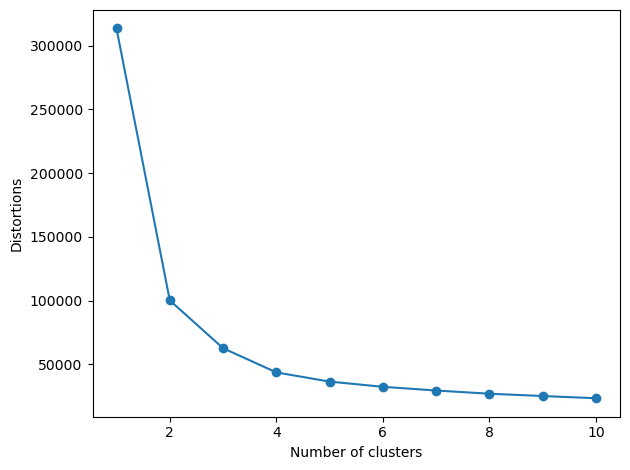

In [95]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = df_enc_scaled.drop('user_id', axis=1)
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Distortions")
plt.tight_layout()
plt.show()

0.5360984863422089


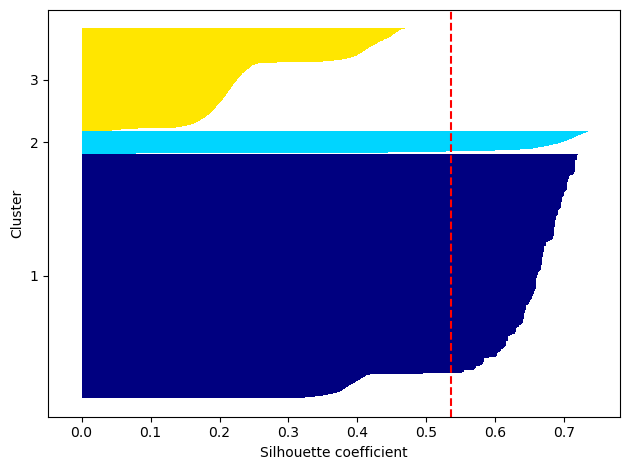

In [96]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
print(silhouette_avg)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14265 entries, 1 to 27595
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          14265 non-null  object 
 1   traffic_session  14265 non-null  object 
 2   total_click      14265 non-null  int64  
 3   total_order      14265 non-null  int64  
 4   total_item       14265 non-null  Int64  
 5   revenue          14265 non-null  float64
 6   total_session    14265 non-null  int64  
 7   recency          14265 non-null  float64
dtypes: Int64(1), float64(2), int64(3), object(2)
memory usage: 1016.9+ KB
None


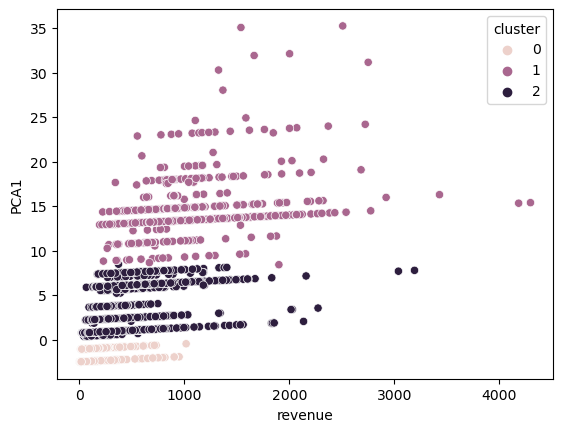

In [97]:
import seaborn as sns
from sklearn.decomposition import PCA

km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=0).fit(X)


labels = list(km.labels_)

result = df_grouped.copy()

result['cluster'] = labels

print(df_grouped.info())

# Decompose fields
pca = PCA(n_components=2)

transform = pca.fit_transform(df_enc_scaled.drop('user_id', axis=1).values)

result[['PCA1', 'PCA2']] = transform

sns.scatterplot(data=result, y= 'PCA1', x='revenue', hue='cluster',)
plt.show()

In [98]:
pivot_table = result.pivot_table(
    values=['recency', 'revenue','total_order', 'total_item', 'total_session', 'total_click'],
    index='cluster',
    aggfunc=['mean', 'max', 'min', 'median']
)

pivot_table

mean                                                 \
            recency     revenue total_click total_item total_order   
cluster                                                              
0        134.659638   64.890957    1.099926   1.099926    1.099926   
1        126.467797  999.062917    4.553672  16.526554    1.442938   
2        135.051230  316.796450    2.491250   5.292163    1.289120   

                          max                                                  \
        total_session recency      revenue total_click total_item total_order   
cluster                                                                         
0            1.099926   336.0  1016.900002           2          2           2   
1            4.553672   336.0  4298.560001          11         36           4   
2            2.491250   336.0  3193.349991           6         10           4   

                          min                                                 \
        total_session recency     revenue total_click total_item total_order   
cluster                                                                        
0                   2     0.0    1.500000           1          1           1   
1                  11     0.0  192.279999           4         10           1   
2                   6     0.0   21.320000           2          3           1   

                       median                                                 \
        total_session recency     revenue total_click total_item total_order   
cluster                                                                        
0                   1   121.0   44.000000           1        1.0           1   
1                   4   121.0  875.800003           4       16.0           1   
2                   2   121.0  240.000000           2        4.0           1   

                       
        total_session  
cluster                
0                   1  
1                   4  
2                   2

**Hierarchical**

0.5360984863422089


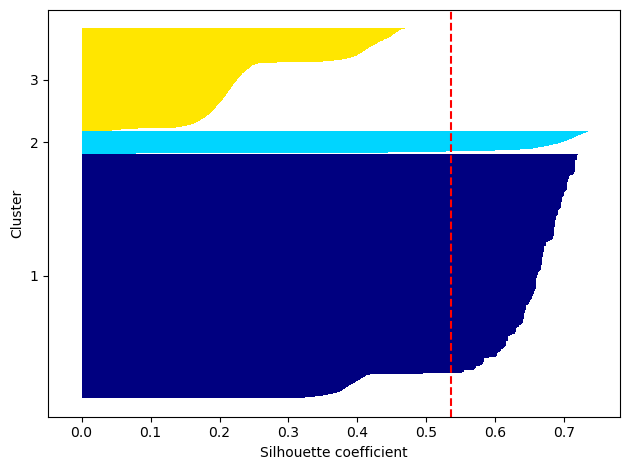

In [99]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')

y_agg = km.fit_predict(X)

cluster_labels = np.unique(y_agg)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_agg, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_agg == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
print(silhouette_avg)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.tight_layout()
plt.show()

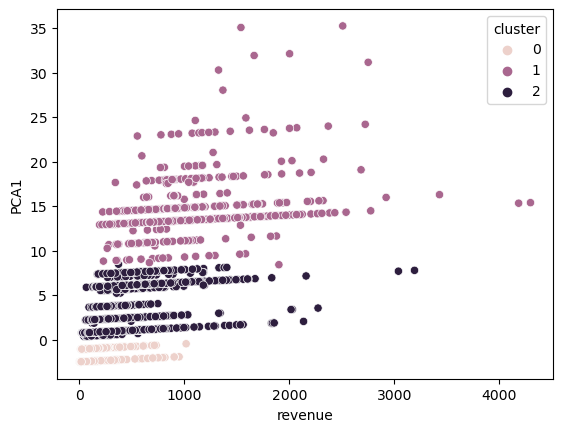

In [100]:
import seaborn as sns
from sklearn.decomposition import PCA

labels = list(y_km)

result = df_grouped.copy()

result['cluster'] = labels

# Decompose fields
pca = PCA(n_components=2)

transform = pca.fit_transform(df_enc_scaled.drop('user_id', axis=1).values)

result[['PCA1', 'PCA2']] = transform

sns.scatterplot(data=result, y= 'PCA1', x='revenue', hue='cluster',)
plt.show()

In [101]:
pivot_table = result.pivot_table(
    values=['recency', 'revenue','total_order', 'total_item', 'total_session', 'total_click'],
    index='cluster',
    aggfunc=['mean', 'max', 'min', 'median']
)

pivot_table

mean                                                 \
            recency     revenue total_click total_item total_order   
cluster                                                              
0        134.659638   64.890957    1.099926   1.099926    1.099926   
1        126.467797  999.062917    4.553672  16.526554    1.442938   
2        135.051230  316.796450    2.491250   5.292163    1.289120   

                          max                                                  \
        total_session recency      revenue total_click total_item total_order   
cluster                                                                         
0            1.099926   336.0  1016.900002           2          2           2   
1            4.553672   336.0  4298.560001          11         36           4   
2            2.491250   336.0  3193.349991           6         10           4   

                          min                                                 \
        total_session recency     revenue total_click total_item total_order   
cluster                                                                        
0                   2     0.0    1.500000           1          1           1   
1                  11     0.0  192.279999           4         10           1   
2                   6     0.0   21.320000           2          3           1   

                       median                                                 \
        total_session recency     revenue total_click total_item total_order   
cluster                                                                        
0                   1   121.0   44.000000           1        1.0           1   
1                   4   121.0  875.800003           4       16.0           1   
2                   2   121.0  240.000000           2        4.0           1   

                       
        total_session  
cluster                
0                   1  
1                   4  
2                   2

**DBSCAN**

In [102]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.3, min_samples=5)
clusters = dbscan.fit_predict(X)

if len(set(clusters)) > 1:
    silhouette_avg = silhouette_score(X, clusters)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("Silhouette Score cannot be calculated for a single cluster")

Silhouette Score: 0.2239767614267441


0.2239767614267441


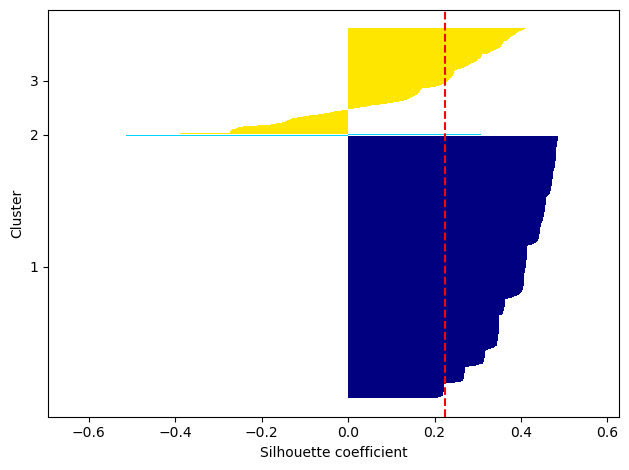

In [103]:
dbscan = DBSCAN(eps=0.3, min_samples=5)

y_dbscan = dbscan.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_dbscan, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_dbscan == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
print(silhouette_avg)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.tight_layout()
plt.show()

**Kernel Kmeans**

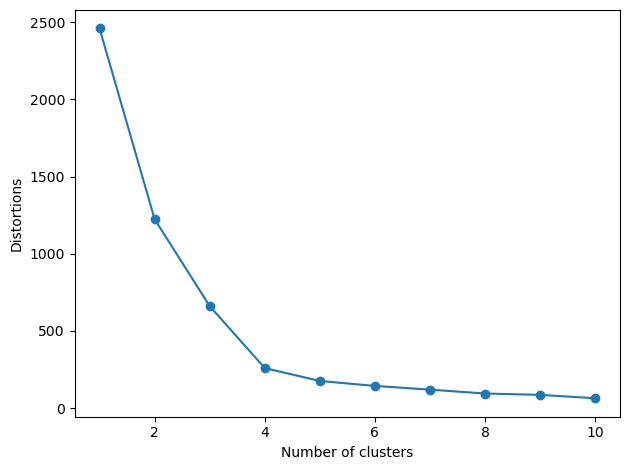

In [104]:
from sklearn.decomposition import KernelPCA

# Kernel K-Means

# Apply Kernel PCA with RBF kernel
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=1.0)

X_kpca = kpca.fit_transform(X)

distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    
    km.fit(X_kpca)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Distortions")
plt.tight_layout()
plt.show()

0.6834594305093297


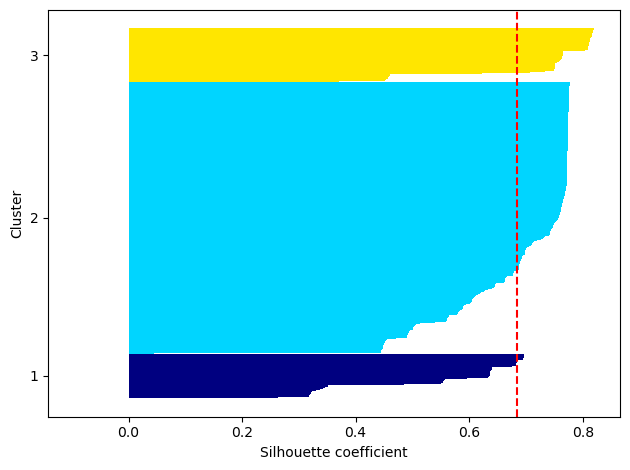

In [112]:
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_km = km.fit_predict(X_kpca)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_kpca, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
print(silhouette_avg)
plt.axvline(silhouette_avg,
            color='red',
            linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel("Cluster")
plt.xlabel("Silhouette coefficient")
plt.tight_layout()
plt.show()

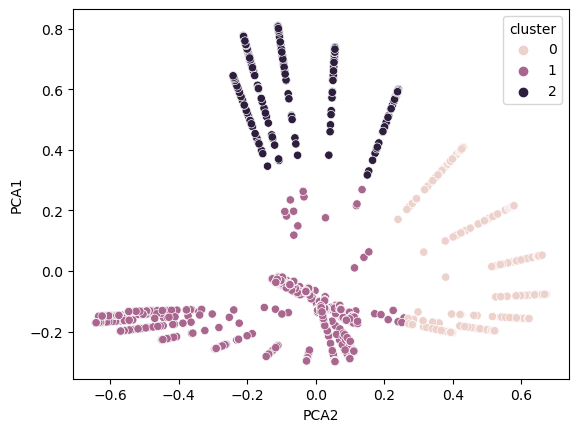

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14265 entries, 1 to 27595
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          14265 non-null  object 
 1   traffic_session  14265 non-null  object 
 2   total_click      14265 non-null  int64  
 3   total_order      14265 non-null  int64  
 4   total_item       14265 non-null  Int64  
 5   revenue          14265 non-null  float64
 6   total_session    14265 non-null  int64  
 7   recency          14265 non-null  float64
 8   cluster          14265 non-null  int32  
 9   PCA1             14265 non-null  float64
 10  PCA2             14265 non-null  float64
dtypes: Int64(1), float64(4), int32(1), int64(3), object(2)
memory usage: 1.3+ MB
None


,user_id,traffic_session,total_click,total_order,total_item,revenue,total_session,recency,cluster,PCA1,PCA2
1,10012,Adwords,1,1,1,37.680000,1,274.0,1,-0.288666,0.099264
2,10018,Email,4,2,10,350.770000,4,121.0,1,-0.116294,0.014914
4,10026,Adwords,1,1,1,39.990002,1,31.0,1,-0.148905,-0.632788
6,10033,Email,2,1,4,89.959999,2,0.0,1,-0.158757,0.022413
9,10043,Email,2,1,4,266.000000,2,92.0,1,-0.179105,0.025993


In [113]:
result = df_grouped.copy()
result['cluster'] = y_km

result[['PCA1', 'PCA2']] = X_kpca

sns.scatterplot(data=result, y= 'PCA1', x='PCA2', hue='cluster',)
plt.show()


print(result.info())
result.head()

In [114]:
pivot_table = result.pivot_table(
    values=['recency', 'revenue','total_order', 'total_item', 'total_session', 'total_click'],
    index='cluster',
    aggfunc=['mean', 'max', 'min', 'median']
)

pivot_table

mean                                                 \
            recency     revenue total_click total_item total_order   
cluster                                                              
0        236.731014   55.560609    1.000000        1.0    1.000000   
1        133.676535  241.691867    1.951963   4.018623    1.236367   
2         51.776704   57.553142    1.000000        1.0    1.000000   

                          max                                                  \
        total_session recency      revenue total_click total_item total_order   
cluster                                                                         
0            1.000000   336.0   325.000000           1          1           1   
1            1.951963   336.0  4298.560001          11         36           4   
2            1.000000   121.0   300.000000           1          1           1   

                          min                                             \
        total_session recency revenue total_click total_item total_order   
cluster                                                                    
0                   1   152.0    2.59           1          1           1   
1                  11     0.0    1.50           1          1           1   
2                   1     0.0    3.50           1          1           1   

                       median                                                 \
        total_session recency     revenue total_click total_item total_order   
cluster                                                                        
0                   1   244.0   39.950001           1        1.0           1   
1                   1   121.0  111.360001           2        2.0           1   
2                   1    61.0   40.950001           1        1.0           1   

                       
        total_session  
cluster                
0                   1  
1                   2  
2                   1

In [108]:
result.to_csv('./result/segmentation-result.csv', index=False)